# Preprocessing

In [1]:
import pandas as pd
import numpy as np

all_data = pd.read_csv('forest_dataset.csv')

labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

In [2]:
from sklearn.model_selection import train_test_split

train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)

# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


Train the `KNeighborsClassifier` on the dataset.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier()
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)

accuracy_score(test_labels, y_pred)

0.7365

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [4]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': list(range(1, 11)),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)

# Train the classifier
clf_grid.fit(train_feature_matrix, train_labels)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Let's output the best parameters

In [5]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [6]:
optimal_clf = KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')

# Training ...
optimal_clf.fit(train_feature_matrix, train_labels)

pred_prob = optimal_clf.predict_proba(test_feature_matrix)

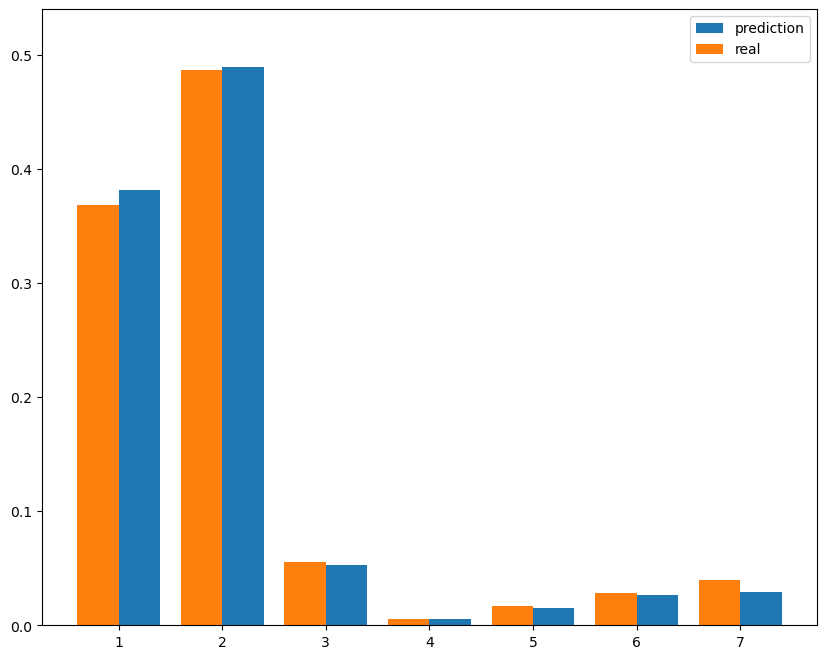

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

### 1. What is the quality of the model on the test sample?

In [8]:
y_pred_knn = optimal_clf.predict(test_feature_matrix)

accuracy_knn = accuracy_score(test_labels, y_pred_knn)

print(accuracy_knn)

0.785


### 2. Compare it with the quality of logistic regression. Which model is better? Why?

Сначала обучим модель логистической регрессии:

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='saga')

param_grid = {
    'C': np.arange(1, 5),
    'penalty': ['l1', 'l2'],
}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')

search.fit(feature_matrix, labels)

accuracy_log = accuracy_score(labels, search.best_estimator_.predict(feature_matrix))

/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr

Как это пофиксить я так и не понял, но в файле с семинара точно так же!

Посмотрим на `accuracy_score` каждой модели:

In [10]:
print(f'Accuracy kNN: {accuracy_knn}')
print(f'Accuracy Log: {accuracy_log}')

Accuracy kNN: 0.785
Accuracy Log: 0.6418


Ну, понятно, что kNN лучше, т.к. `accuracy_score` у него больше.

### 3. What are the pros and cons of the k Nearest Neighbors method?

Преимущества:
 1. простота и интуитивная понятность
 2. не требует дополнительных предположений о распределении данных
 3. может использоваться для многоклассовой классификации

Недостатки:
 1. неэффективность при большом объёме данных
 2. чувствительность к шуму в данных
 3. проблемы с категориальными признаками (например, датасет с лунами)

### 4. Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

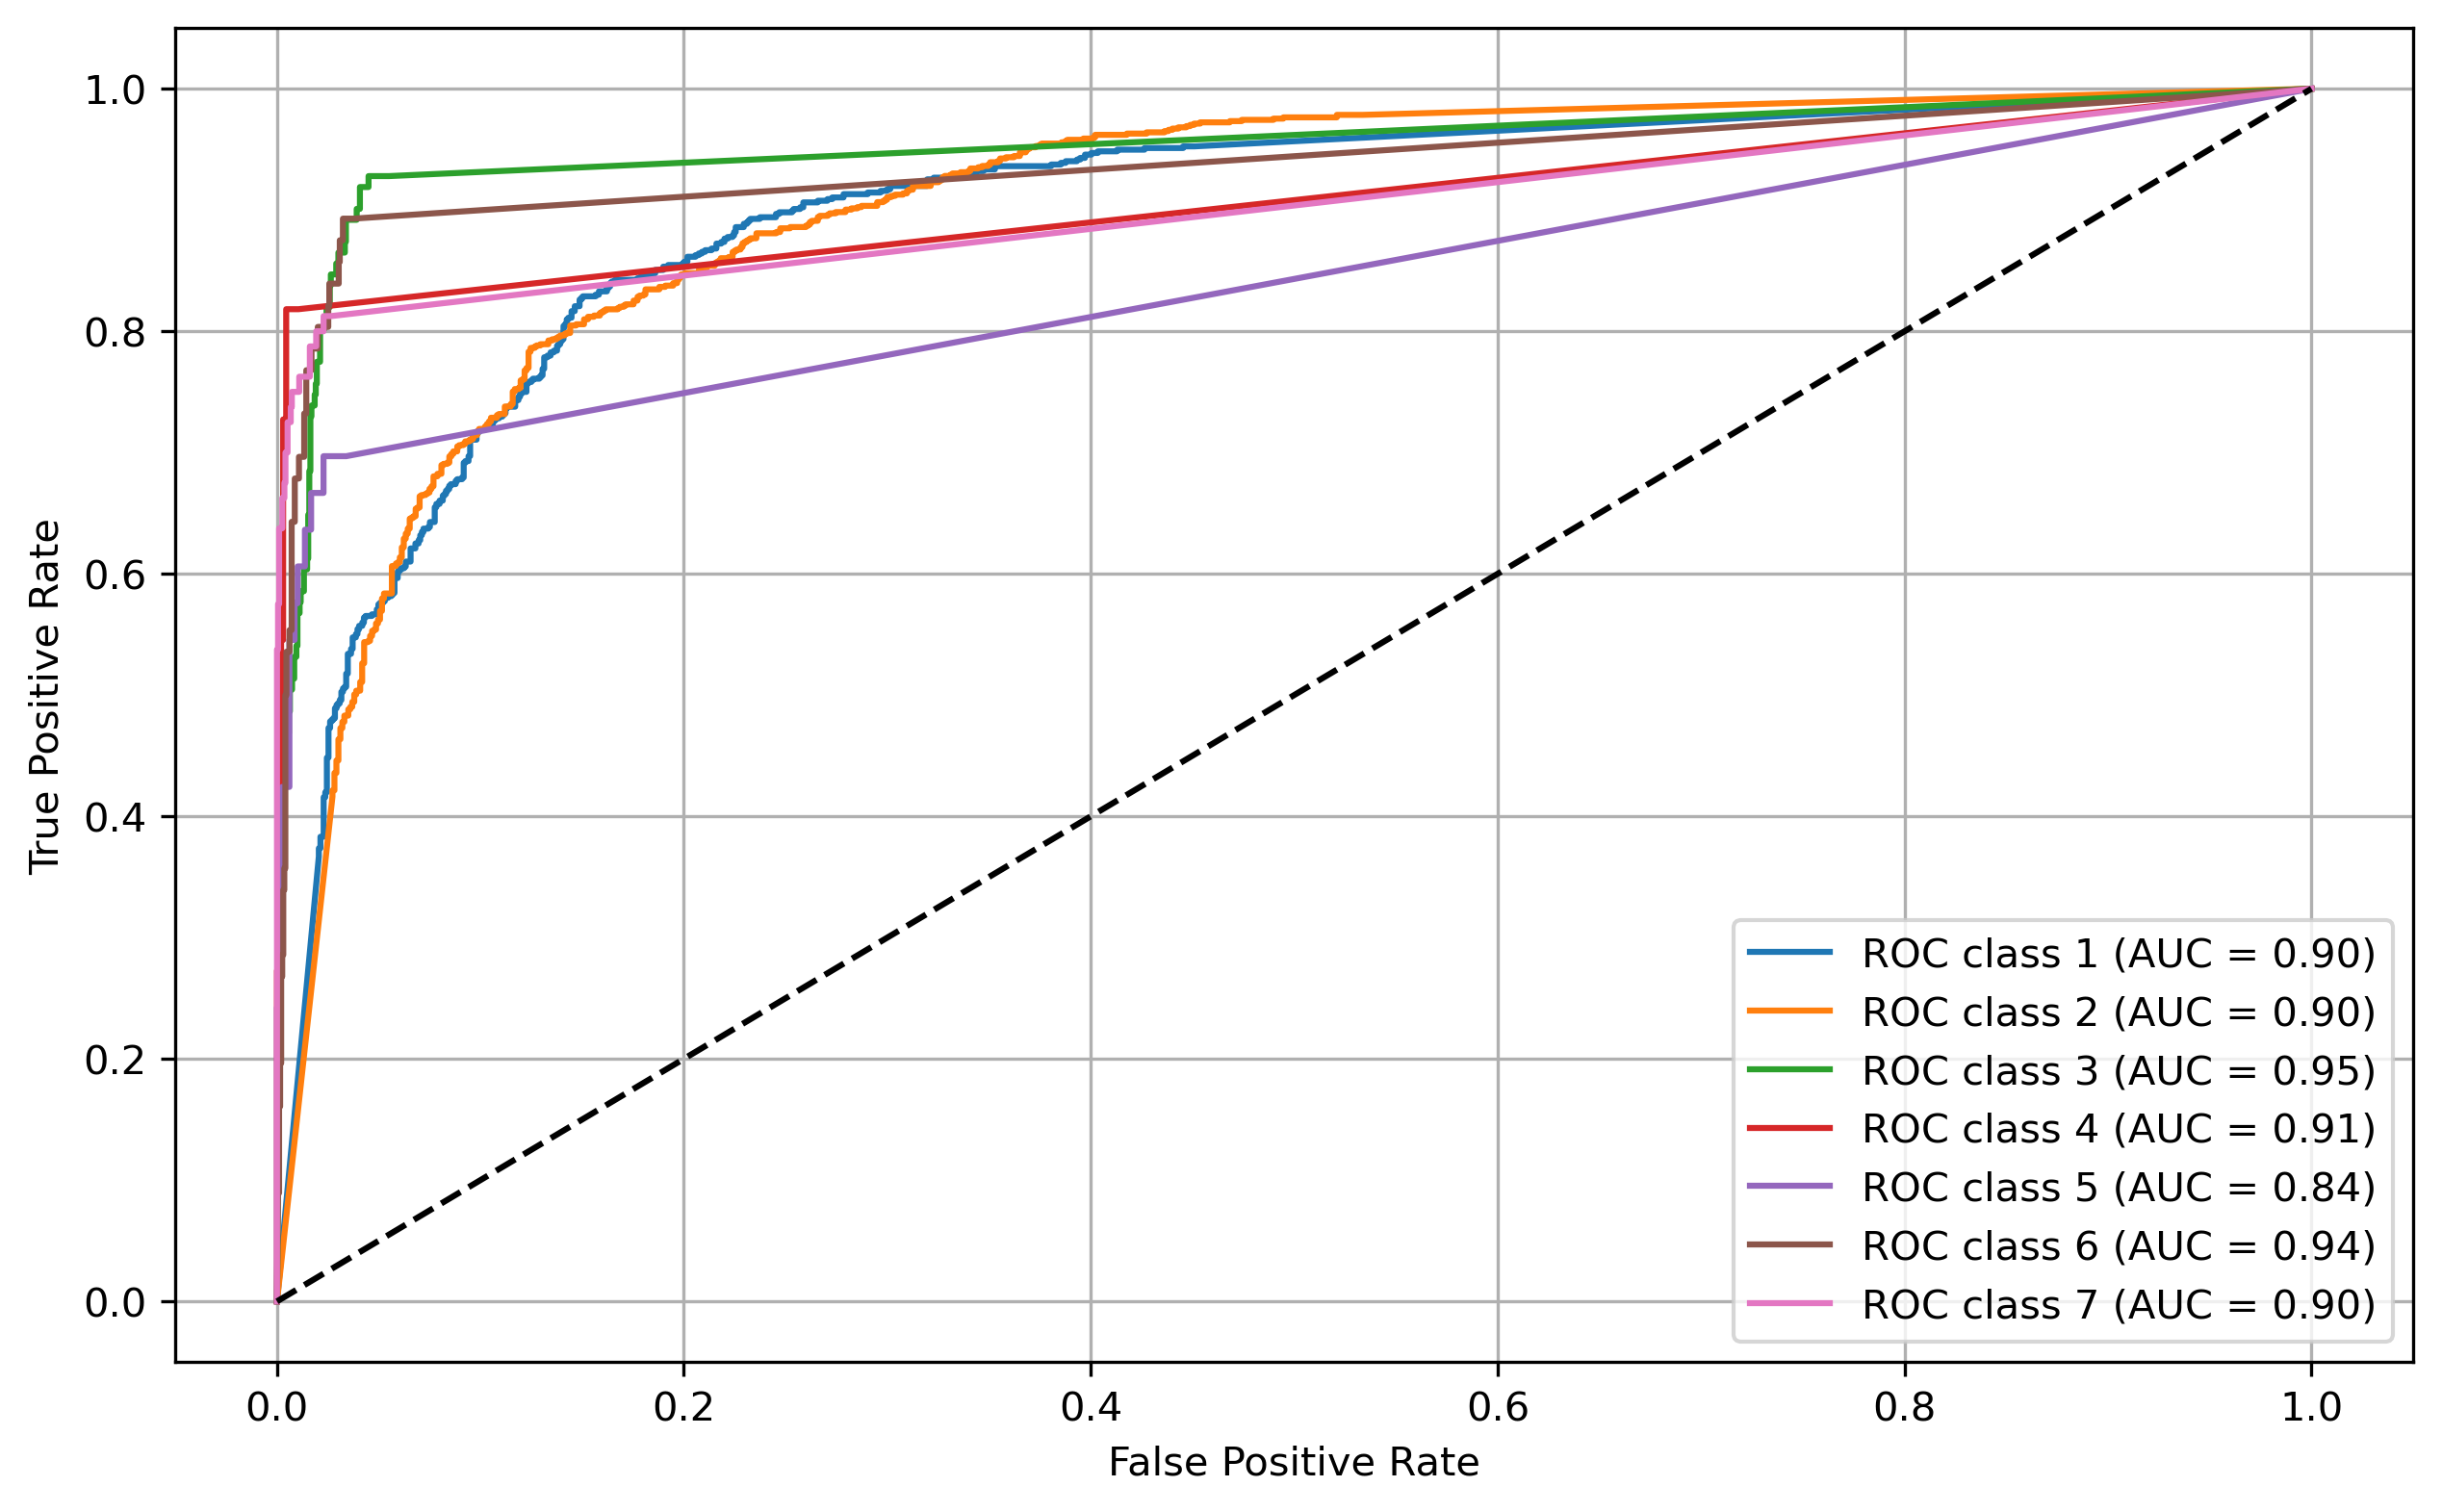

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

test_labels_bin = label_binarize(test_labels, classes=np.unique(labels))

plt.figure(figsize=(10, 6), dpi=300)

for i in (range(len(np.unique(labels)))):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'ROC class {i+1} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()